# Evaluation of HoVer-Net performance

## Edited by Salma, and Klara 


Test images were:

MFGTMPcx7_170702000001_G14f03d0.png  
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170702090001_B22f15d0.png  
MFGTMPcx7_170731090001_D11f13d0.png
MFGTMPcx7_170702090001_C08f14d0.png  
MFGTMPcx7_170731090001_I12f05d0.png
MFGTMPcx7_170702090001_H04f01d0.png  
MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170702090001_P07f14d0.png  
MFGTMPcx7_170803210001_J12f29d0.png

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sb

import skimage.io
import skimage.morphology
import skimage.segmentation

In [2]:

from mat4py import loadmat

### Evalution metrics and functions

In [3]:
import numpy as np
import pandas as pd


def intersection_over_union(ground_truth, prediction):
    
    # Count objects
    true_objects = len(np.unique(ground_truth))
    pred_objects = len(np.unique(prediction))
    
    # Compute intersection
    h = np.histogram2d(ground_truth.flatten(), prediction.flatten(), bins=(true_objects,pred_objects))
    intersection = h[0]
    
    # Area of objects
    area_true = np.histogram(ground_truth, bins=true_objects)[0]
    area_pred = np.histogram(prediction, bins=pred_objects)[0]
    
    # Calculate union
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)
    union = area_true + area_pred - intersection
    
    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    
    # Compute Intersection over Union
    union[union == 0] = 1e-9
    IOU = intersection/union
    
    return IOU
    


def measures_at(threshold, IOU):
    
    matches = IOU > threshold
    
    true_positives = np.sum(matches, axis=1) == 1   # Correct objects
    false_positives = np.sum(matches, axis=0) == 0  # Extra objects
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects
    
    assert np.all(np.less_equal(true_positives, 1))
    assert np.all(np.less_equal(false_positives, 1))
    assert np.all(np.less_equal(false_negatives, 1))
    
    TP, FP, FN = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
    
    f1 = 2*TP / (2*TP + FP + FN + 1e-9)
    
    return f1, TP, FP, FN

# Compute Average Precision for all IoU thresholds

def compute_af1_results(ground_truth, prediction, results, image_name):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    if IOU.shape[0] > 0:
        jaccard = np.max(IOU, axis=0).mean()
    else:
        jaccard = 0.0
    
    # Calculate F1 score at all thresholds
    for t in np.arange(0.5, 1.0, 0.05):
        f1, tp, fp, fn = measures_at(t, IOU)
        res = {"Image": image_name, "Threshold": t, "F1": f1, "Jaccard": jaccard, "TP": tp, "FP": fp, "FN": fn}
        row = len(results)
        results.loc[row] = res
        
    return results

# Count number of False Negatives at 0.7 IoU

def get_false_negatives(ground_truth, prediction, results, image_name, threshold=0.9):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    true_objects = len(np.unique(ground_truth))
    if true_objects <= 1:
        return results
        
    area_true = np.histogram(ground_truth, bins=true_objects)[0][1:]
    true_objects -= 1
    
    # Identify False Negatives
    matches = IOU > threshold
    false_negatives = np.sum(matches, axis=1) == 0  # Missed objects

    data = np.asarray([ 
        area_true.copy(), 
        np.array(false_negatives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Negative"])])
        
    return results

def get_false_positives(ground_truth, prediction, results, image_name, threshold=0.9):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    pred_objects = len(np.unique(prediction))
    if pred_objects <= 1:
        return results
        
    area_pred = np.histogram(prediction, bins = pred_objects)[0][1:]
    pred_objects -= 1
    # Identify False Positives
    matches = IOU > threshold
    false_positives = np.sum(matches, axis=0) == 0  # Missed objects
    
    data = np.asarray([ 
        area_pred.copy(), 
        np.array(false_positives, dtype=np.int32)
    ])

    results = pd.concat([results, pd.DataFrame(data=data.T, columns=["Area", "False_Positive"])])
        
    return results

# Count the number of splits and merges

def get_splits_and_merges(ground_truth, prediction, results, image_name):

    # Compute IoU
    IOU = intersection_over_union(ground_truth, prediction)
    
    matches = IOU > 0.1
    merges = np.sum(matches, axis=0) > 1
    splits = np.sum(matches, axis=1) > 1
    r = {"Image_Name":image_name, "Merges":np.sum(merges), "Splits":np.sum(splits)}
    results.loc[len(results)+1] = r
    return results

In [4]:
import numpy as np
import skimage.segmentation
import skimage.io
#import keras.backend as K
#import tensorflow as tf

debug = False

def channel_precision(channel, name):
    def precision_func(y_true, y_pred):
        y_pred_tmp = K.cast(tf.equal( K.argmax(y_pred, axis=-1), channel), "float32")
        true_positives = K.sum(K.round(K.clip(y_true[:,:,:,channel] * y_pred_tmp, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred_tmp, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
    
        return precision
    precision_func.__name__ = name
    return precision_func


def channel_recall(channel, name):
    def recall_func(y_true, y_pred):
        y_pred_tmp = K.cast(tf.equal( K.argmax(y_pred, axis=-1), channel), "float32")
        true_positives = K.sum(K.round(K.clip(y_true[:,:,:,channel] * y_pred_tmp, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true[:,:,:,channel], 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
    
        return recall
    recall_func.__name__ = name
    return recall_func


## PROBMAP TO CONTOURS TO LABEL

def probmap_to_contour(probmap, threshold = 0.5):
    # assume 2D input
    outline = probmap >= threshold
    
    return outline

def contour_to_label(outline, image):
    # see notebook contours_to_labels for why we do what we do here
    
    # get connected components
    labels = skimage.morphology.label(outline, background=1)
    skimage.morphology.remove_small_objects(labels, min_size = 100, in_place = True)
    
    n_ccs = np.max(labels)

    # buffer label image
    filtered_labels = np.zeros_like(labels, dtype=np.uint16)

    # relabel as we don't know what connected component the background has been given before
    label_index = 1
    
    # start at 1 (0 is contours), end at number of connected components
    for i in range(1, n_ccs + 1):

        # get mask of connected compoenents
        mask = labels == i

        # get mean
        mean = np.mean(np.take(image.flatten(),np.nonzero(mask.flatten())))

        if(mean > 50/255):
            filtered_labels[mask] = label_index
            label_index = label_index + 1
            
    return filtered_labels


## PROBMAP TO PRED TO LABEL

def probmap_to_pred(probmap, boundary_boost_factor):
    # we need to boost the boundary class to make it more visible
    # this shrinks the cells a little bit but avoids undersegmentation
    pred = np.argmax(probmap * [1, 1, boundary_boost_factor], -1)
    
    return pred


def pred_to_label(pred, cell_min_size, cell_label=1):
    # Only marks interior of cells (cell_label = 1 is interior, cell_label = 2 is boundary)
    cell=(pred == cell_label)
    # fix cells
    cell = skimage.morphology.remove_small_holes(cell, area_threshold=cell_min_size)
    cell = skimage.morphology.remove_small_objects(cell, min_size=cell_min_size)
    
    # label cells only
    [label, num] = skimage.morphology.label(cell, return_num=True)
    return label


def compare_two_labels(label_model, label_gt, return_IoU_matrix):
    
    # get number of detected nuclei
    nb_nuclei_gt = np.max(label_gt)
    nb_nuclei_model = np.max(label_model)
    
    # catch the case of an empty picture in model and gt
    if nb_nuclei_gt == 0 and nb_nuclei_model == 0:
        if(return_IoU_matrix):
            return [0, 0, 1, np.empty(0)]     
        else:
            return [0, 0, 1]
    
    # catch the case of empty picture in model
    if nb_nuclei_model == 0:
        if(return_IoU_matrix):
            return [0, nb_nuclei_gt, 0, np.empty(0)]     
        else:
            return [0, nb_nuclei_gt, 0]
    
    # catch the case of empty picture in gt
    if nb_nuclei_gt == 0:
        if(return_IoU_matrix):
            return [nb_nuclei_model, 0, 0, np.empty(0)]     
        else:
            return [nb_nuclei_model, 0, 0]
    
    # build IoU matrix
    IoUs = np.full((nb_nuclei_gt, nb_nuclei_model), -1, dtype = np.float32)

    # calculate IoU for each nucleus index_gt in GT and nucleus index_pred in prediction    
    # TODO improve runtime of this algorithm
    for index_gt in range(1,nb_nuclei_gt+1):

        nucleus_gt = label_gt == index_gt
        number_gt = np.sum(nucleus_gt)

        for index_model in range(1,nb_nuclei_model+1):
            
            if debug:
                print(index_gt, "/", index_model)
            
            nucleus_model = label_model == index_model 
            number_model = np.sum(nucleus_model)
            
            same_and_1 = np.sum((nucleus_gt == nucleus_model) * nucleus_gt)
            
            IoUs[index_gt-1,index_model-1] = same_and_1 / (number_gt + number_model - same_and_1)
    
    # get matches and errors
    detection_map = (IoUs > 0.5)
    nb_matches = np.sum(detection_map)

    detection_rate = IoUs * detection_map
    
    nb_overdetection = nb_nuclei_model - nb_matches
    nb_underdetection = nb_nuclei_gt - nb_matches
    
    mean_IoU = np.mean(np.sum(detection_rate, axis = 1))
    
    if(return_IoU_matrix):
        result = [nb_overdetection, nb_underdetection, mean_IoU, IoUs]
    else:
        result = [nb_overdetection, nb_underdetection, mean_IoU]
    return result

def splits_and_merges_3_class(y_model_pred, y_gt_pred):
    
    # get segmentations
    label_gt = pred_to_label(y_gt_pred, cell_min_size=2)
    label_model = pred_to_label(y_model_pred, cell_min_size=2)
    
    # compare labels
    result = compare_two_labels(label_model, label_gt, False)
        
    return result

def splits_and_merges_boundary(y_model_outline, y_gt_outline, image):
    
    # get segmentations
    label_gt = contour_to_label(y_gt_outline, image)
    label_model = contour_to_label(y_model_outline, image)
    
    # compare labels
    result = compare_two_labels(label_model, label_gt, False)
        
    return result

### Auxiliary visualization function

In [5]:
# Display prediction along with segmentation to visualize errors

def show(ground_truth, prediction, threshold=0.5, image_name="N"):
    
    # Compute Intersection over Union
    IOU = intersection_over_union(ground_truth, prediction)
    
    # Create diff map
    diff = np.zeros(ground_truth.shape + (3,))
    A = ground_truth.copy()
    B = prediction.copy()
    A[A > 0] = 1
    B[B > 0] = 1
    D = A - B
    #diff[D > 0,:2] = 1
    #diff[D < 0,1:] = 1
    
    # Object-level errors
    C = IOU.copy()
    C[C>=threshold] = 1
    C[C<threshold] = 0
    missed = np.where(np.sum(C,axis=1) == 0)[0]
    extra = np.where(np.sum(C,axis=0) == 0)[0]

    for m in missed:
        diff[ground_truth == m+1, 0] = 1
    for e in extra:
        diff[prediction == e+1, 2] = 1
    
    # Display figures
    fig, ax = plt.subplots(1, 4, figsize=(18,6))
    ax[0].imshow(ground_truth)
    ax[0].set_title("True objects:"+str(len(np.unique(ground_truth))))
    ax[1].imshow(diff)
    ax[1].set_title("Segmentation errors:"+str(len(missed)))
    ax[2].imshow(prediction)
    ax[2].set_title("Predicted objects:"+str(len(np.unique(prediction))))
    ax[3].imshow(IOU)
    ax[3].set_title(image_name)

# Run the evaluation

## This part is for evaluating hovernet models

In [11]:
all_images = os.listdir('../../training/HoVerNet/dataset/Test/images/')
all_images

['MFGTMPcx7_170702000001_G14f03d0.png',
 'MFGTMPcx7_170702090001_B22f15d0.png',
 'MFGTMPcx7_170702090001_C08f14d0.png',
 'MFGTMPcx7_170702090001_H04f01d0.png',
 'MFGTMPcx7_170702090001_P07f14d0.png',
 'MFGTMPcx7_170731090001_B14f09d0.png',
 'MFGTMPcx7_170731090001_D11f13d0.png',
 'MFGTMPcx7_170731090001_I12f05d0.png',
 'MFGTMPcx7_170801050001_G02f01d0.png',
 'MFGTMPcx7_170803210001_J12f29d0.png']

### *test if data was correctly place*

0
192
(1104, 1104, 3)


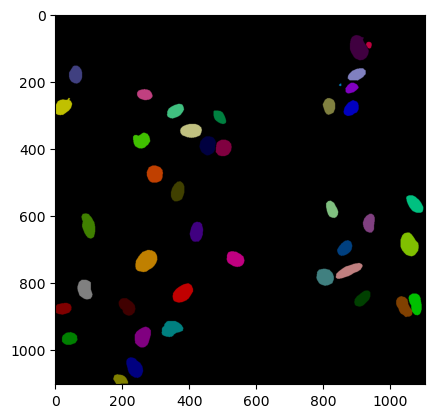

In [7]:
img_filename = os.path.join('../../training/HoVerNet/dataset/Test/annotations/', all_images[5])
ground_truth = skimage.io.imread(img_filename)
plt.imshow(ground_truth)
print(np.min(ground_truth))
print(np.max(ground_truth))
print(ground_truth.shape)

In [13]:
import scipy.io


../../training/HoVerNet/dataset/Test/annotations/MFGTMPcx7_170731090001_B14f09d0.mat
dict_keys(['__header__', '__version__', '__globals__', 'inst_centroid', 'inst_map'])
(1104, 1104)


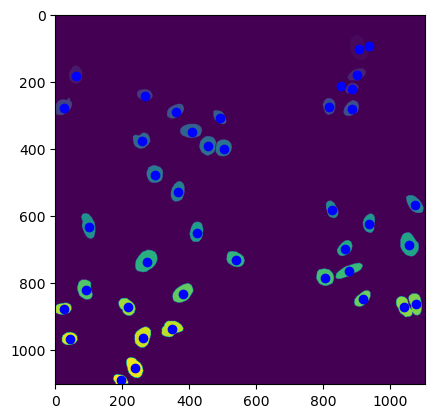

In [8]:
import scipy
pred_filename = os.path.join("../../training/HoVerNet/dataset/Test/annotations/", all_images[5])
print(pred_filename.replace('.png','.mat'))
prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))
print(prediction.keys())
plt.imshow(prediction['inst_map'])
print(prediction['inst_map'].shape)
x = prediction['inst_centroid'][:,0]
y = prediction['inst_centroid'][:,1]
plt.scatter(x,y,c = 'blue')

../../training/HoVerNet/output/Test/37_out/mat/MFGTMPcx7_170731090001_B14f09d0.mat
dict_keys(['__header__', '__version__', '__globals__', 'inst_map', 'inst_uid', 'inst_centroid', 'raw_map'])
(1104, 1104)


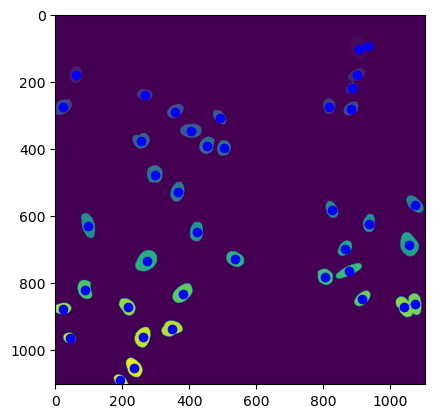

In [13]:
import scipy.io


pred_filename = os.path.join("../../training/HoVerNet/output/Test/37_out/mat/", all_images[5])
print(pred_filename.replace('.png','.mat'))
prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))
print(prediction.keys())
plt.imshow(prediction['inst_map'])
print(prediction['inst_map'].shape)
x = prediction['inst_centroid'][:,0]
y = prediction['inst_centroid'][:,1]
plt.scatter(x,y,c = 'blue')



## Run evaluation

MFGTMPcx7_170702000001_G14f03d0.png
MFGTMPcx7_170702090001_B22f15d0.png
MFGTMPcx7_170702090001_C08f14d0.png
MFGTMPcx7_170702090001_H04f01d0.png
MFGTMPcx7_170702090001_P07f14d0.png
MFGTMPcx7_170731090001_B14f09d0.png
MFGTMPcx7_170731090001_D11f13d0.png
MFGTMPcx7_170731090001_I12f05d0.png
MFGTMPcx7_170801050001_G02f01d0.png
MFGTMPcx7_170803210001_J12f29d0.png


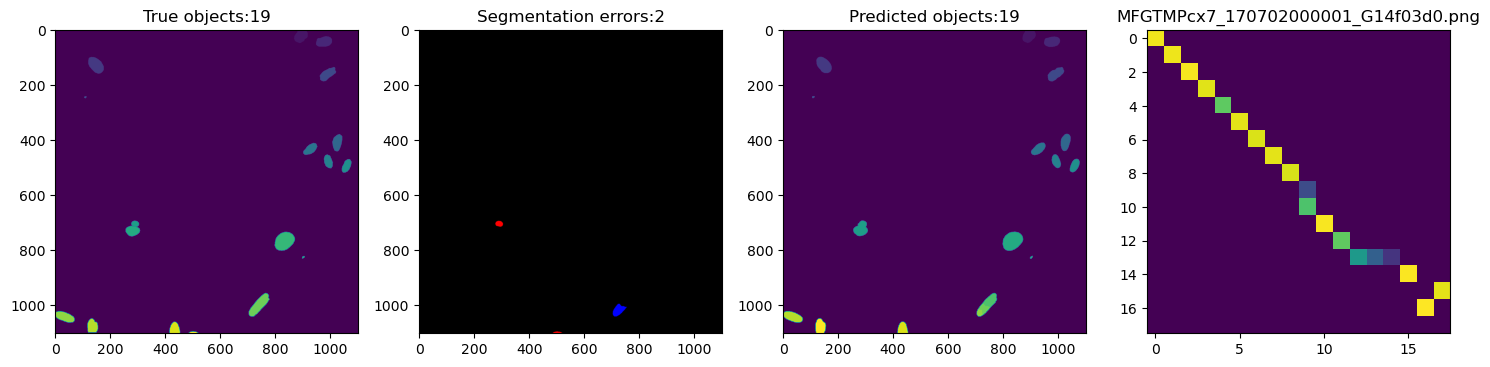

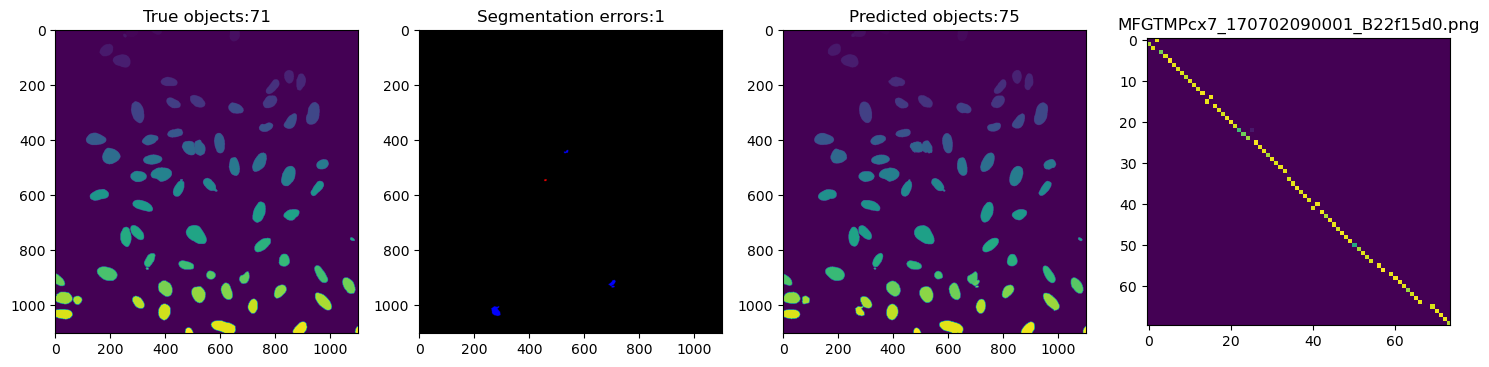

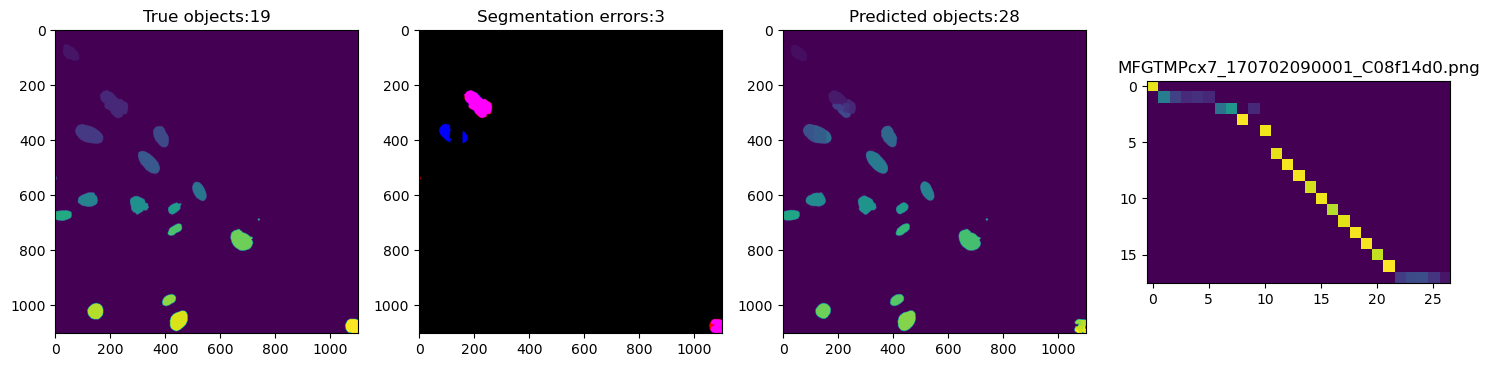

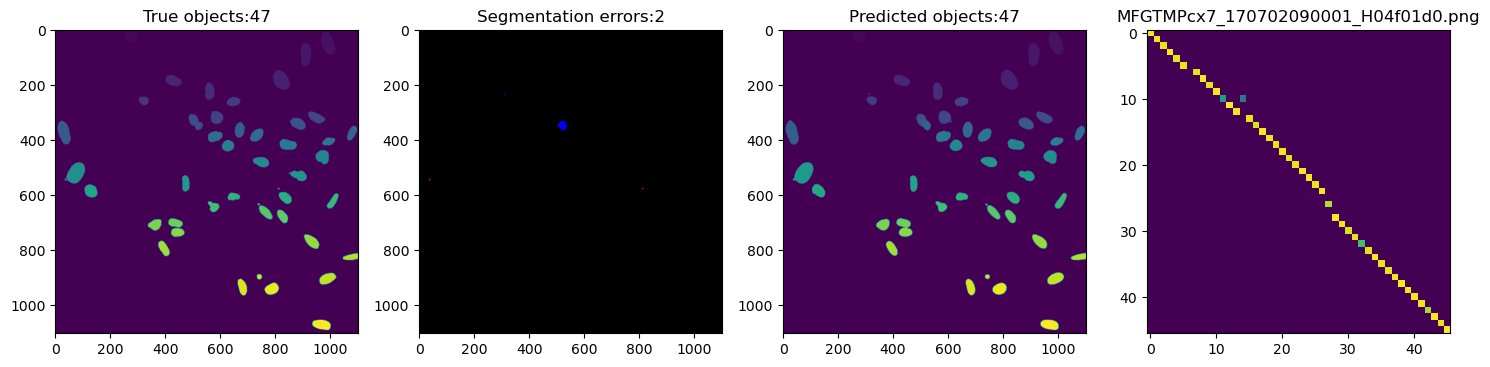

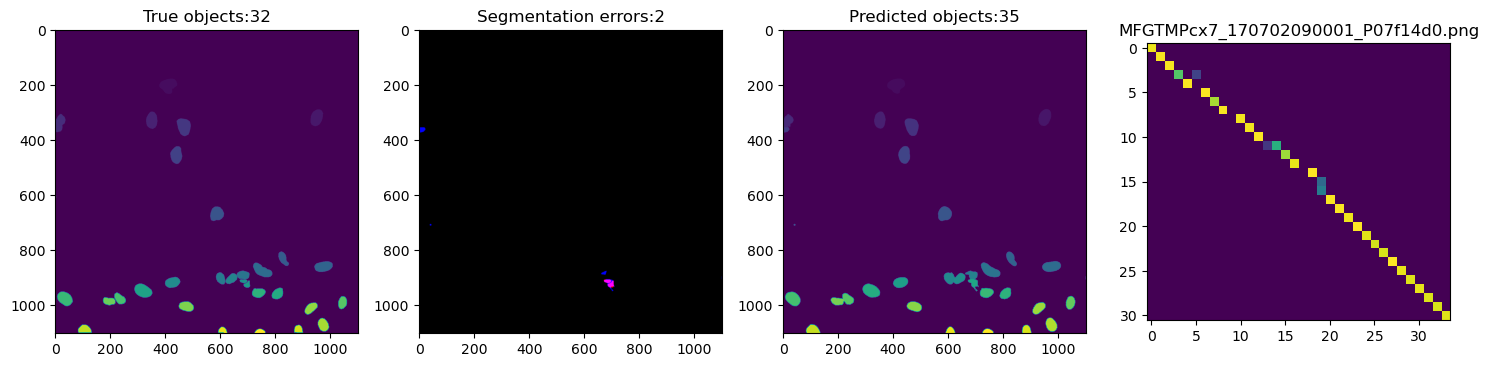

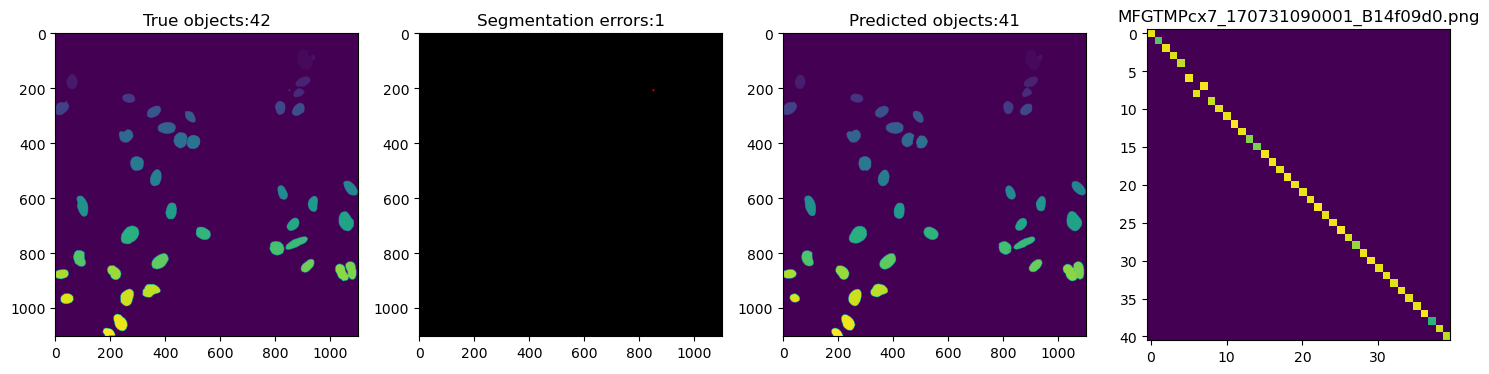

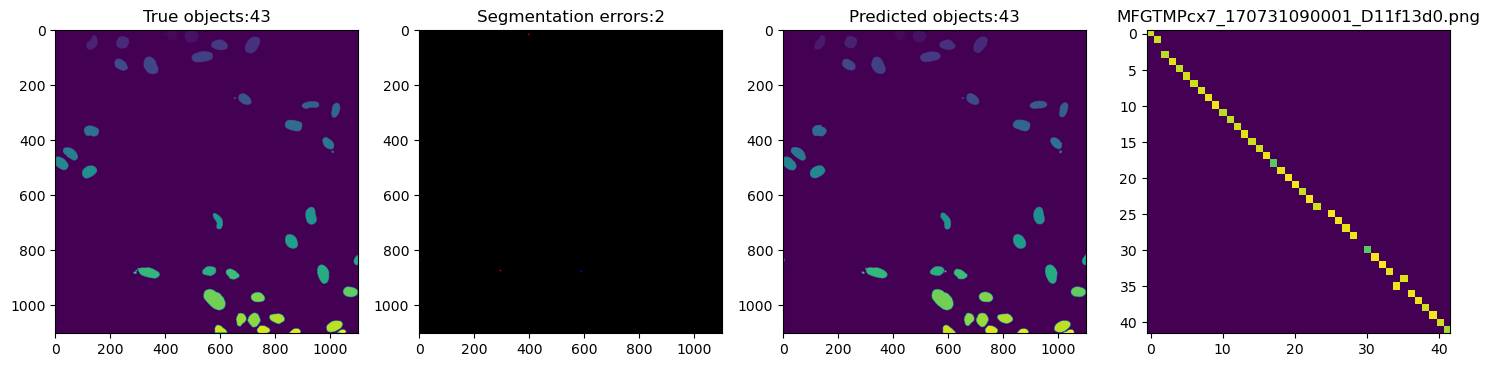

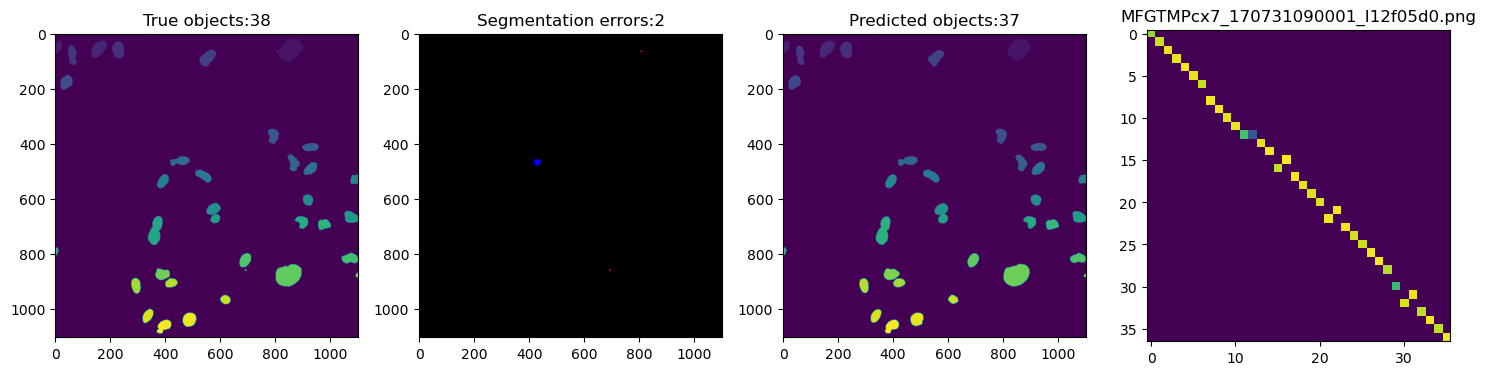

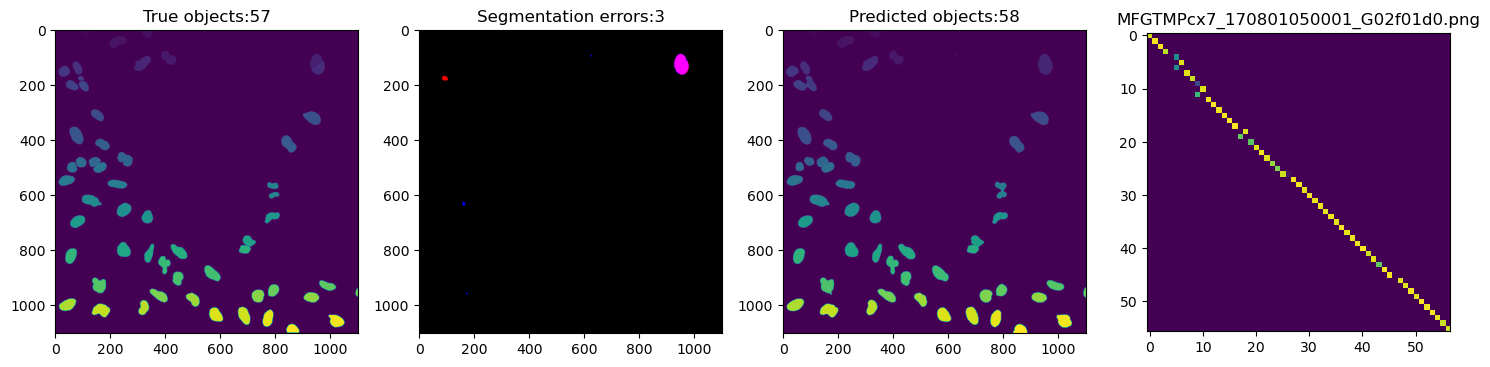

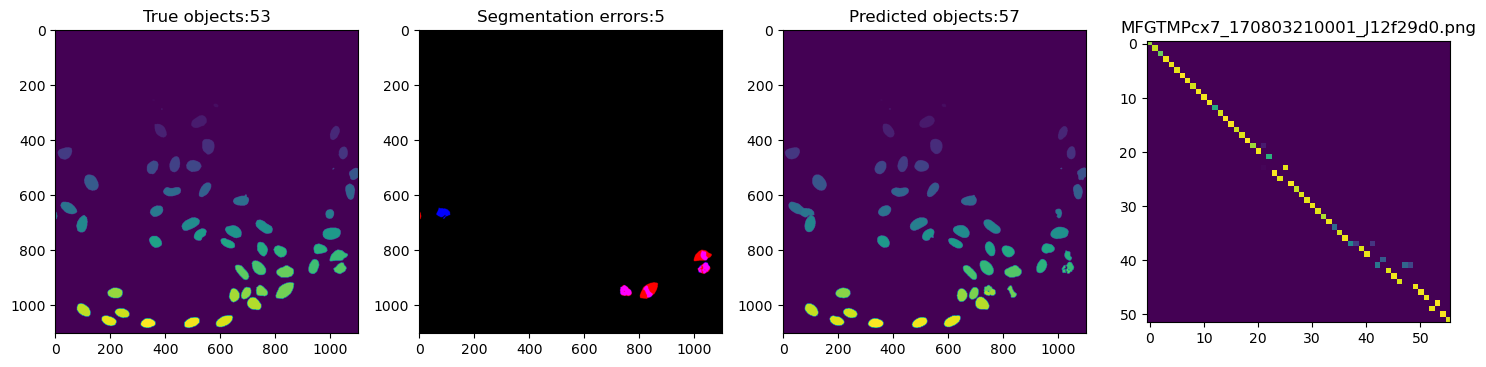

In [14]:
#all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

for image_name in all_images:
    print(image_name)
    # Load ground truth data
    img_filename = os.path.join("../../training/HoVerNet/dataset/Test/annotations/", image_name)
    ground_truth = scipy.io.loadmat(img_filename.replace('.png','.mat'))['inst_map']#skimage.io.imread(img_filename)
    #ground_truth = ground_truth.squeeze()
    if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
    ground_truth = skimage.morphology.label(ground_truth)
    
    # Transform to label matrix
    #ground_truth = skimage.morphology.label(ground_truth)
    
    # Load predictions
    pred_filename = os.path.join("../../training/HoVerNet/output/Test/37_out/mat/", image_name)
    prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))['inst_map']

    if len(prediction.shape) == 3:
        prediction = rgb2lab(prediction)
        prediction = prediction[:,:,0]
    
    # Apply object dilation
    #if config_vars["object_dilation"] > 0:
    #    struct = skimage.morphology.square(config_vars["object_dilation"])
    #    prediction = skimage.morphology.dilation(prediction, struct)
    #elif config_vars["object_dilation"] < 0:
    #    struct = skimage.morphology.square(-config_vars["object_dilation"])
    #    prediction = skimage.morphology.erosion(prediction, struct)
        
    ####################################################################################    
    #### Testing prediction with no small objects on annot and prediction #####
    ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=25) 
    prediction = skimage.morphology.remove_small_objects(prediction, min_size=25)
    #####################################################################################
    
    # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
    ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
    prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
    
    # Compute evaluation metrics
    results = compute_af1_results(
        ground_truth, 
        prediction, 
        results, 
        image_name
    )
    
    false_negatives = get_false_negatives(
        ground_truth, 
        prediction, 
        false_negatives, 
        image_name
    )
    
    false_positives = get_false_positives(
        ground_truth, 
        prediction, 
        false_positives, 
        image_name
    )
    
    splits_merges = get_splits_and_merges(
        ground_truth, 
        prediction, 
        splits_merges, 
        image_name
    )
    
    # Display an example image
    #if image_name == all_images[0]:
    show(ground_truth, prediction, image_name=image_name)

# Report of results

,Image,Threshold,F1,Jaccard,TP,FP,FN
3,MFGTMPcx7_170702090001_H04f01d0.png,0.725,0.860870,0.893629,39.6,6.4,6.4
6,MFGTMPcx7_170731090001_D11f13d0.png,0.725,0.852381,0.873113,35.8,6.2,6.2
1,MFGTMPcx7_170702090001_B22f15d0.png,0.725,0.844444,0.854200,60.8,13.2,9.2
5,MFGTMPcx7_170731090001_B14f09d0.png,0.725,0.844444,0.904624,34.2,5.8,6.8
7,MFGTMPcx7_170731090001_I12f05d0.png,0.725,0.832877,0.890039,30.4,5.6,6.6
8,MFGTMPcx7_170801050001_G02f01d0.png,0.725,0.821239,0.857004,46.4,10.6,9.6
4,MFGTMPcx7_170702090001_P07f14d0.png,0.725,0.793846,0.801372,25.8,8.2,5.2
9,MFGTMPcx7_170803210001_J12f29d0.png,0.725,0.751852,0.805017,40.6,15.4,11.4
0,MFGTMPcx7_170702000001_G14f03d0.png,0.725,0.705556,0.798530,12.7,5.3,5.3
2,MFGTMPcx7_170702090001_C08f14d0.png,0.725,0.591111,0.591443,13.3,13.7,4.7


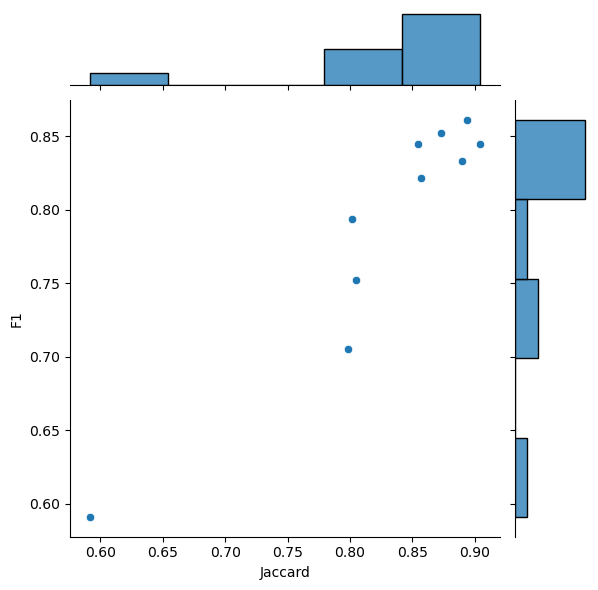

In [15]:
# Display accuracy results

average_performance = results.groupby("Threshold")[['F1','Jaccard']].mean().reset_index()

R = results.groupby("Image").mean().reset_index()
g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

average_performance
R.sort_values(by="F1",ascending=False)

,Threshold,F1,Jaccard
0,0.50,0.907008,0.826897
1,0.55,0.894834,0.826897
2,0.60,0.891593,0.826897
3,0.65,0.884196,0.826897
4,0.70,0.867828,0.826897
5,0.75,0.839247,0.826897
6,0.80,0.829761,0.826897
7,0.85,0.800963,0.826897
8,0.90,0.719012,0.826897
9,0.95,0.264177,0.826897


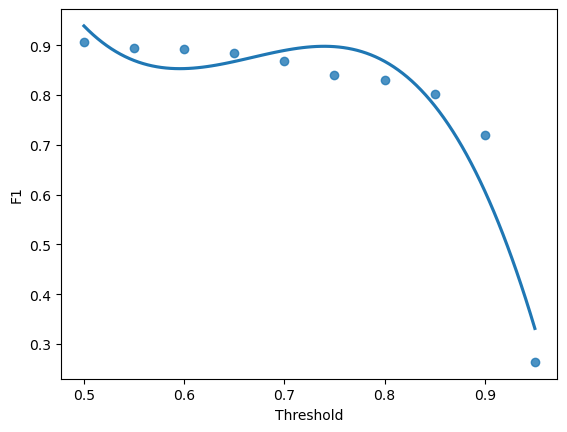

In [16]:
# Plot accuracy results

sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
average_performance

In [17]:
# Compute and print Average F1

average_F1_score = average_performance["F1"].mean()
jaccard_index = average_performance["Jaccard"].mean()
print("Average F1 score:", average_F1_score)
print("Jaccard index:", jaccard_index)

Average F1 score: 0.789861972912739
Jaccard index: 0.8268971696006193


In [18]:
# Summarize False Negatives by area

false_negatives = false_negatives[false_negatives["False_Negative"] == 1]

false_negatives.groupby(
    pd.cut(
        false_negatives["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Negative"].sum()

C:\Users\salma\AppData\Local\Temp\ipykernel_22920\4003444665.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  false_negatives.groupby(


Area
Tiny nuclei      21
Small nuclei     28
Normal nuclei    39
Large nuclei     13
Name: False_Negative, dtype: object

In [29]:
falseP = false_positives[false_positives["False_Positive"] == 1]

FP_Area_chart = falseP.groupby(
    pd.cut(
        falseP["Area"], 
        [0,100,1000,2100,30000], # Area intervals
        labels=["Tiny nuclei","Small nuclei","Normal nuclei","Large nuclei"],
    )
)["False_Positive"].sum()

total_Positives = len(false_positives)
print(FP_Area_chart)

print("FDR Tiny:", "%.4f" % (FP_Area_chart["Tiny nuclei"]/total_Positives))

print("FDR Small:", "%.4f" % (FP_Area_chart["Small nuclei"]/total_Positives))

print("FDR Normal:", "%.4f" % (FP_Area_chart["Normal nuclei"]/total_Positives))

print("FDR Large:", "%.4f" % (FP_Area_chart["Large nuclei"]/total_Positives))


Area
Tiny nuclei      20
Small nuclei     54
Normal nuclei    38
Large nuclei      8
Name: False_Positive, dtype: object
FDR Tiny: 0.0465
FDR Small: 0.1256
FDR Normal: 0.0884
FDR Large: 0.0186


In [30]:
# Summarize splits and merges

print("Splits:",np.sum(splits_merges["Splits"]))
print("Merges:",np.sum(splits_merges["Merges"]))

Splits: 10
Merges: 4


In [19]:
# Report false positives

print("Extra objects (false postives):",results[results["Threshold"].round(3) == 0.9].sum()["FP"])

Extra objects (false postives): 120


In [33]:
thresh = 0.9


FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
Total = FP + TP

print("Extra objects (false postives):",FP)

print("True positives:",TP)

print("Total objects:",Total)

print("False discovery rate:", FP/Total)

Extra objects (false postives): 120
True positives: 310
Total objects: 430
False discovery rate: 0.27906976744186046


# **EPOCHS COMPARISON**

In [ ]:
#all_images = data_partitions[partition]
from skimage.color import rgb2gray,rgb2lab

epochs_results = pd.DataFrame(columns=["Average F1 Score", "Average Jaccard Index", "False Negatives", "False Positives", "True Positives", "Detected Objects", "False Discovery Rate"])
best_models = [17,23,37]
for epoch in best_models:

  print("################################################################")
  print("EPOCH", epoch)

  results = pd.DataFrame(columns=["Image", "Threshold", "F1", "Jaccard", "TP", "FP", "FN"])
  false_negatives = pd.DataFrame(columns=["False_Negative", "Area"])
  false_positives = pd.DataFrame(columns=["False_Positive", "Area"])
  splits_merges = pd.DataFrame(columns=["Image_Name", "Merges", "Splits"])

  for image_name in all_images:
      # Load ground truth data  
      img_filename = os.path.join("../../training/HoVerNet/dataset/Test/annotations/", image_name)
      ground_truth = scipy.io.loadmat(img_filename.replace('.png','.mat'))['inst_map']#skimage.io.imread(img_filename)
      #ground_truth = ground_truth.squeeze()
      if len(ground_truth.shape) == 3:
        ground_truth = rgb2lab(ground_truth)
        ground_truth = ground_truth[:,:,0]
    
      ground_truth = skimage.morphology.label(ground_truth)
    
    
       # Load predictions
      pred_filename = os.path.join("../../training/HoVerNet/output/Test/",str(epoch)+"_out/mat/", image_name)
      prediction = scipy.io.loadmat(pred_filename.replace('.png','.mat'))['inst_map']
      
      # Apply object dilation
      #if config_vars["object_dilation"] > 0:
      #    struct = skimage.morphology.square(config_vars["object_dilation"])
      #    prediction = skimage.morphology.dilation(prediction, struct)
      #elif config_vars["object_dilation"] < 0:
      #    struct = skimage.morphology.square(-config_vars["object_dilation"])
      #    prediction = skimage.morphology.erosion(prediction, struct)
          
      ####################################################################################    
      #### Testing prediction with no small objects on annot and prediction #####
      ground_truth = skimage.morphology.remove_small_objects(ground_truth, min_size=25) 
      prediction = skimage.morphology.remove_small_objects(prediction, min_size=25)
      #####################################################################################
      
      # Relabel objects (cut margin of 30 pixels to make a fair comparison with DeepCell)
      ground_truth = skimage.segmentation.relabel_sequential(ground_truth)[0] #[30:-30,30:-30])[0]
      prediction = skimage.segmentation.relabel_sequential(prediction)[0] #[30:-30,30:-30])[0]
      
      # Compute evaluation metrics
      results = compute_af1_results(
          ground_truth, 
          prediction, 
          results, 
          image_name
      )
      
      false_negatives = get_false_negatives(
          ground_truth, 
          prediction, 
          false_negatives, 
          image_name
      )
      
      false_positives = get_false_positives(
          ground_truth, 
          prediction, 
          false_positives, 
          image_name
      )
      
      splits_merges = get_splits_and_merges(
          ground_truth, 
          prediction, 
          splits_merges, 
          image_name
      )
      
      # Display an example image
      #if image_name == all_images[0]:
      #show(ground_truth, prediction, image_name=image_name)


  # Display accuracy results
  
  
  average_performance = results.groupby("Threshold")[['F1','Jaccard']].mean().reset_index()
 
  
  R = results.groupby("Image").mean().reset_index()
  #g = sb.jointplot(data=R[R["F1"] > 0.4], x="Jaccard", y="F1")

  #average_performance
  R.sort_values(by="F1",ascending=False)

  # Plot accuracy results

  #sb.regplot(data=average_performance, x="Threshold", y="F1", order=3, ci=None)
  print(average_performance)

    
  with open('../../training/HoVerNet/'+str(epoch)+'_test_log.csv','w') as file:
    print(average_performance['F1'],file=file)
    file.close()
  


  # Compute and print Average F1

  F1_score_90 = average_performance["F1"][8] # I want only 90%
 
  #average_performance["F1"].mean()
  jaccard_index = average_performance["Jaccard"].mean()
  print("Average F1 score:", F1_score_90 )
  print("Jaccard index:", jaccard_index)


  # calculate true postives and false positives
  thresh = 0.9

  FP = results[results["Threshold"].round(3) == thresh].sum()["FP"]
  TP = results[results["Threshold"].round(3) == thresh].sum()["TP"]
  FN = results[results["Threshold"].round(3) == thresh].sum()["FN"]
  Total = FP + TP

  print("False negatives:",FN)
  print("False postives:",FP)
  print("True positives:",TP)

  print("Total objects:",Total)

  print("False discovery rate:", FP/Total)

  epochs_results.loc[epoch] = [F1_score_90 , jaccard_index, FN, FP, TP, Total, FP/Total]

  print('#############################################')

################################################################
EPOCH 17
   Threshold        F1   Jaccard
0       0.50  0.903336  0.821311
1       0.55  0.903336  0.821311
2       0.60  0.888010  0.821311
3       0.65  0.877053  0.821311
4       0.70  0.846765  0.821311
5       0.75  0.825529  0.821311
6       0.80  0.817716  0.821311
7       0.85  0.783096  0.821311
8       0.90  0.697900  0.821311
9       0.95  0.225093  0.821311
Average F1 score: 0.6978998140781372
Jaccard index: 0.8213106132168398
False negatives: 111
False postives: 126
True positives: 300
Total objects: 426
False discovery rate: 0.29577464788732394
#############################################
################################################################
EPOCH 23
   Threshold        F1   Jaccard
0       0.50  0.895388  0.812522
1       0.55  0.895388  0.812522
2       0.60  0.884631  0.812522
3       0.65  0.876373  0.812522
4       0.70  0.854033  0.812522
5       0.75  0.832302  0.812522
6       0.80  0.812

In [35]:
epochs_results.rename(columns={'Average F1 Score':'F1_score_90'},inplace=True)
epochs_results

,F1_score_90,Average Jaccard Index,False Negatives,False Positives,True Positives,Detected Objects,False Discovery Rate
17,0.697900,0.821311,111.0,126.0,300.0,426.0,0.295775
23,0.690334,0.812522,110.0,134.0,301.0,435.0,0.308046
37,0.719012,0.826897,101.0,120.0,310.0,430.0,0.279070


Text(0, 0.5, '')

<Figure size 2000x2000 with 0 Axes>

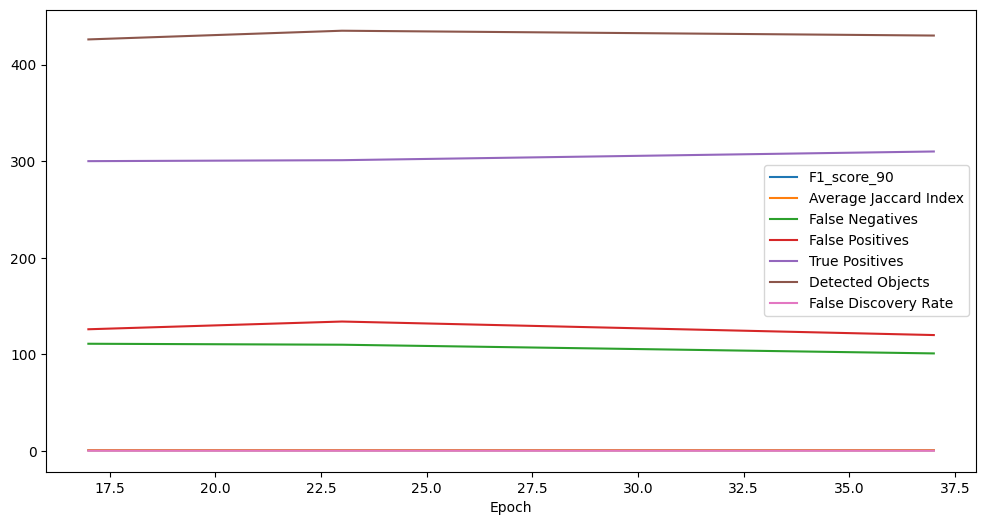

In [36]:
plt.figure(figsize=(20,20))
epochs_results.plot(figsize=(12,6))
plt.xlabel("Epoch")
plt.ylabel("")

Best: 0.7190122426376522
At Epoch: 37


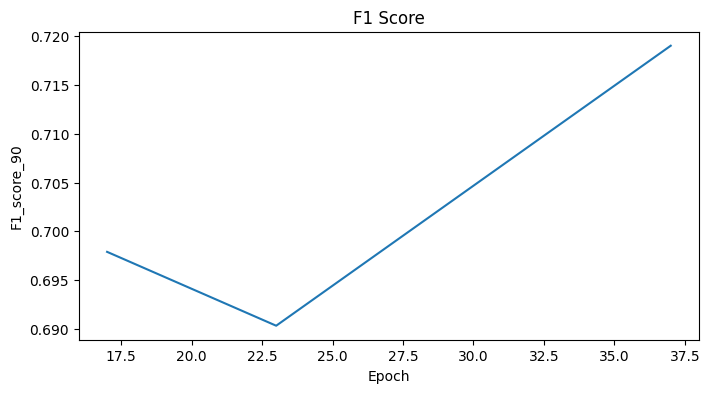

In [37]:
plt.figure(figsize=(8,4))
epochs_results["F1_score_90"].plot()
plt.xlabel("Epoch")
plt.ylabel("F1_score_90")
plt.title("F1 Score")

print('Best:', max(epochs_results["F1_score_90"]))
print('At Epoch:', epochs_results["F1_score_90"].idxmax())

Best: 0.8268971696006193
At Epoch: 37


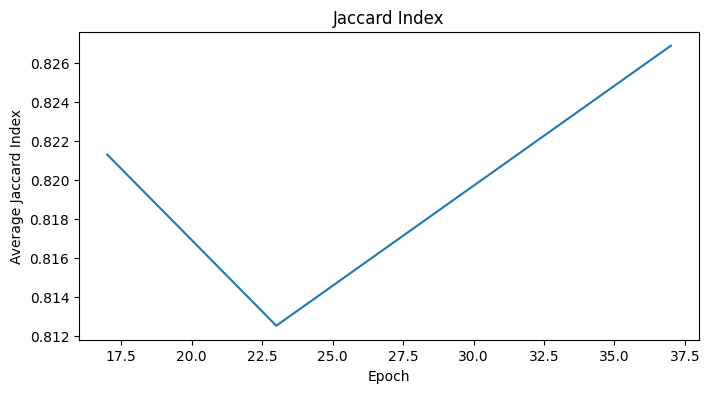

In [38]:
plt.figure(figsize=(8,4))
epochs_results["Average Jaccard Index"].plot()
plt.xlabel("Epoch")
plt.ylabel("Average Jaccard Index")
plt.title("Jaccard Index")
print('Best:', max(epochs_results["Average Jaccard Index"]))
print('At Epoch:', epochs_results["Average Jaccard Index"].idxmax())

Best: 120.0
At Epoch: 37


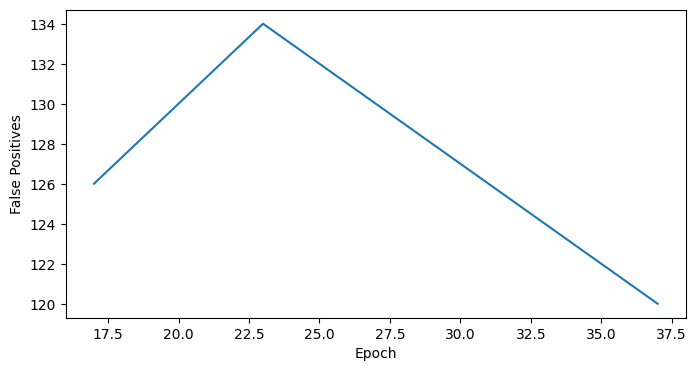

In [39]:
plt.figure(figsize=(8,4))
epochs_results["False Positives"].plot()
plt.xlabel("Epoch")
plt.ylabel("False Positives")
print('Best:', min(epochs_results["False Positives"]))
print('At Epoch:', epochs_results["False Positives"].idxmin())

Best: 101.0
At Epoch: 37


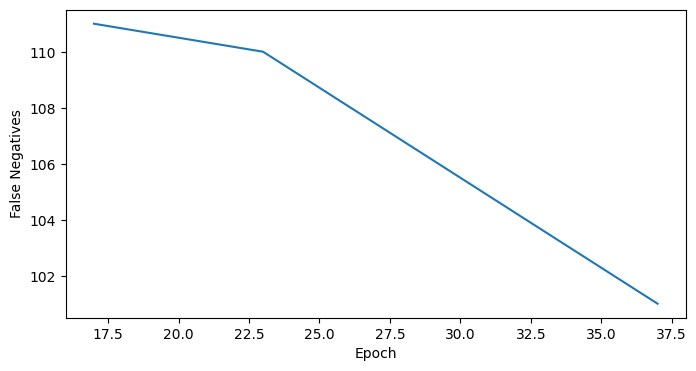

In [40]:
plt.figure(figsize=(8,4))
epochs_results["False Negatives"].plot()
plt.xlabel("Epoch")
plt.ylabel("False Negatives")
print('Best:', min(epochs_results["False Negatives"]))
print('At Epoch:', epochs_results["False Negatives"].idxmin())

Best: 310.0
At Epoch: 37


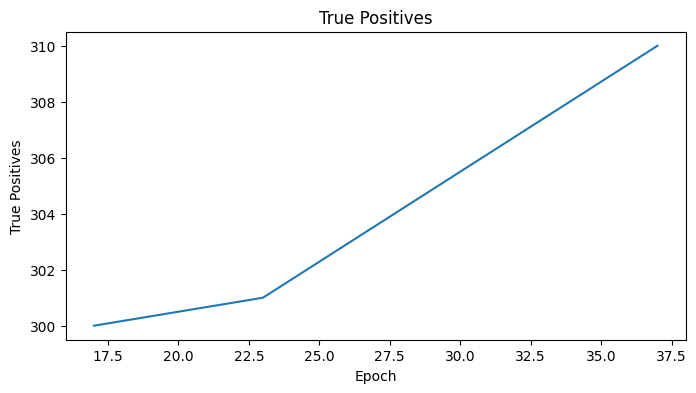

In [41]:
plt.figure(figsize=(8,4))
epochs_results["True Positives"].plot()
plt.xlabel("Epoch")
plt.ylabel("True Positives")
plt.title("True Positives")
print('Best:', max(epochs_results["True Positives"]))
print('At Epoch:', epochs_results["True Positives"].idxmax())

At Epoch: 17


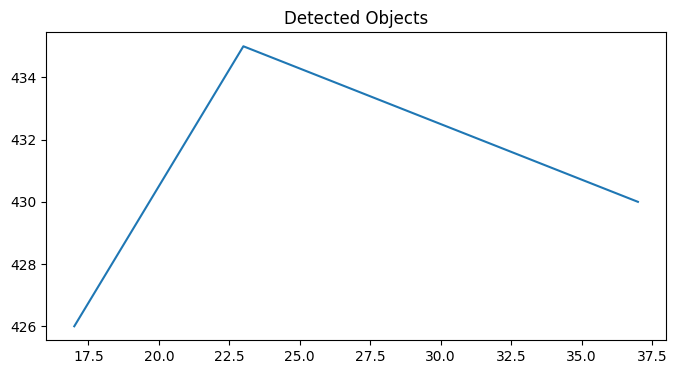

In [42]:
plt.figure(figsize=(8,4))
epochs_results["Detected Objects"].plot()
plt.title("Detected Objects")
print('At Epoch:', epochs_results["Detected Objects"].idxmin())

Best: 0.27906976744186046
At Epoch: 37


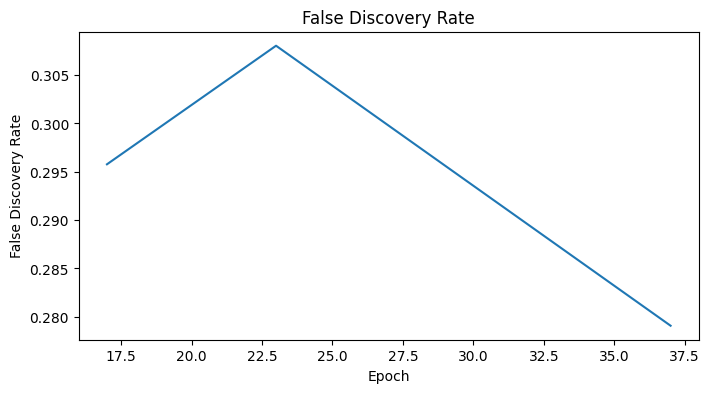

In [43]:
plt.figure(figsize=(8,4))
epochs_results["False Discovery Rate"].plot()
plt.xlabel("Epoch")
plt.ylabel("False Discovery Rate")
plt.title("False Discovery Rate")
print('Best:', min(epochs_results["False Discovery Rate"]))
print('At Epoch:', epochs_results["False Discovery Rate"].idxmin())

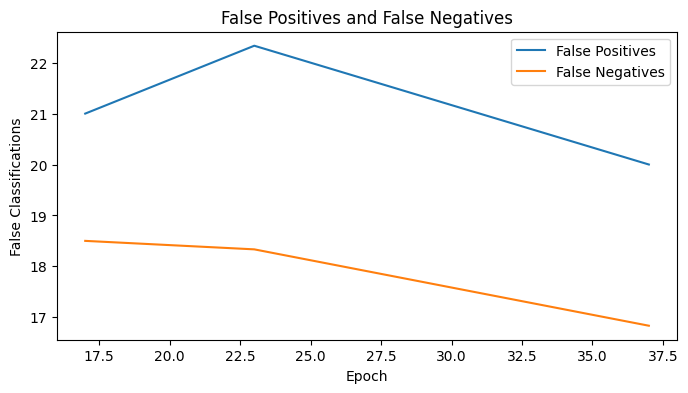

In [44]:
plt.figure(figsize=(8,4))
ax1 = (epochs_results["False Positives"]/6).plot()
ax2 = (epochs_results["False Negatives"]/6).plot()
plt.xlabel("Epoch")
plt.ylabel("False Classifications")
plt.title("False Positives and False Negatives")
plt.legend(["False Positives", "False Negatives"])


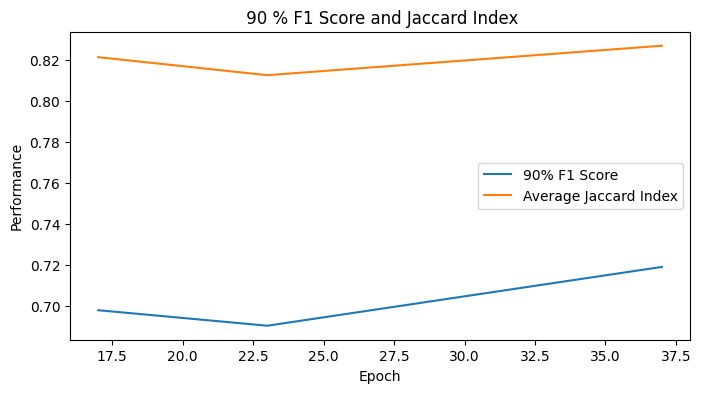

In [45]:
plt.figure(figsize=(8,4))

epochs_results["F1_score_90"].plot()
epochs_results["Average Jaccard Index"].plot()

plt.xlabel("Epoch")
plt.ylabel("Performance")
plt.title(" 90 % F1 Score and Jaccard Index")
plt.legend(["90% F1 Score", "Average Jaccard Index"])
